# ⚙️ **Set-up**

Run the following commands in the terminal:

```terminal
pip install numpy
pip install pandas
pip install openpyxl
pip install datetime
pip install matplotlib
pip install missingno
```

Run the code below to import packages needed for notebook:

In [1]:
# Suppress all warnings (to keep notebook tidy)
import warnings
warnings.filterwarnings("ignore")

# Packages required
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import display, HTML
import missingno as msno
import matplotlib.pyplot as plt

# 📈 **Import raw data**

⚠️ Ensure that the current working directory is in the main folder, e.g. named 'EC1B1'. 

- Inside the main folder, it contains a data folder named `data` 
- All the raw data are under the `data` folder, named `data_spain.xlsx` and `data_united_states.xlsx`
- This notebook is in the main folder as well

**Additional note:** We were unable to find the '_Exchange rates per US dollar (Period Average)_' data under the IMF database. Hence, we used exchange rate of USD per Peseta (Spain currency) instead.

In [2]:
# Import raw data
df_spain_raw = pd.read_excel('./data/data_spain.xlsx')
df_us_raw = pd.read_excel('./data/data_united_states.xlsx')

# Save them under new variables to keep raw data 'untouched'
df_spain = df_spain_raw
df_us = df_us_raw

We now take a quick inspect at the dataframe:

In [3]:
df_spain.head()

,International Financial Statistics (IFS),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,"Economic Activity, Industrial Production, Index","Exchange Rates, US Dollar per Domestic Currenc...","International Reserves and Liquidity, Reserves...","Prices, Consumer Price Index, All items, Index"
1,Jan 1960,NaN,0.016667,233,2.857368
2,Feb 1960,NaN,0.016667,253,2.855049
3,Mar 1960,NaN,0.016667,299,2.851573
4,Apr 1960,NaN,0.016667,326,2.853891


From raw data, we can tell that:
- Titles and headers are messy
- Years are not in `datetime` format
- Missing values
- Nominal exchange rate is currently not Perseta per US dollar, but the inverse

# 🧹 **Basic cleaning**

### **For Spain:**

In the code below, there are several steps that we took to clean the data. The steps are labeled as `#Step`, and the rationale for each step is explained afterwards.

In [4]:
# Step 1
df_spain = df_spain.rename(columns={
    'International Financial Statistics (IFS)': 'date', 
    'Unnamed: 1': 'spain_industrial_index', 
    'Unnamed: 2': 'spain_nominal_exchange_rate', 
    'Unnamed: 3': 'spain_reserves', 'Unnamed: 4': 'spain_price_index'}
    ) [1:]

# Step 2
df_spain['spain_nominal_exchange_rate'] = 1 / df_spain['spain_nominal_exchange_rate']

# Step 3
df_spain['date'] = df_spain['date'].apply(lambda x: datetime.strptime(x, '%b %Y'))

<u>Explanation of steps:</u>
- **Step 1:** We rename the columns to more appropriate names, as well as removing the first row (which is irrelevant) using `[1:]`
- **Step 2:** We take the inverse of the exchange rate, since we are looking for 'exchange rate per US dollar'
- **Step 3:** Convert the dates into `datetime` format, using the function `strptime()` to match the date format

The cleaned dataframe should look as such:

In [5]:
df_spain.head()

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index
1,1960-01-01,NaN,60.0,233,2.857368
2,1960-02-01,NaN,60.0,253,2.855049
3,1960-03-01,NaN,60.0,299,2.851573
4,1960-04-01,NaN,60.0,326,2.853891
5,1960-05-01,NaN,60.0,360,2.845198


Note that there are `NaN` values in `spain_industrial_index` as some early data are not available (will be looked through in detail later)

### **For US:**

We follow similar steps for the US:

In [6]:
# Similar to Step 1 for Spain
df_us = df_us.rename(columns={
    'International Financial Statistics (IFS)': 'date',
    'Unnamed: 1': 'us_reserves',
    'Unnamed: 2': 'us_price_index'}) [1:]

# Similar to Step 3 for Spain
df_us['date'] = df_us['date'].apply(lambda x: datetime.strptime(x, '%b %Y'))

# Inspect the dataframe
df_us.head()

,date,us_reserves,us_price_index
1,1960-01-01,21478.1,13.436946
2,1960-02-01,21395.7,13.482806
3,1960-03-01,21344.7,13.482806
4,1960-04-01,21278,13.528666
5,1960-05-01,21234.3,13.528666


# 🛠 **Data manipulation**

We first merge both datasets:

In [7]:
# Merge based on 'date'
merged_df = pd.merge(df_spain, df_us, on = 'date')

# Inspect the new dataframe, tail() to show industrial index as well
merged_df.tail()

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index,us_reserves,us_price_index
367,1990-08-01,57.138375,97.029,53227.717281,52.200576,78908.838357,60.351608
368,1990-09-01,97.803577,98.467,53790.187718,52.750025,80024.166133,60.856066
369,1990-10-01,100.909947,95.697,55428.040577,53.218335,82852.196532,61.222946
370,1990-11-01,104.110449,93.958,56347.862332,53.165017,83059.402774,61.360525
371,1990-12-01,88.202071,95.234,56004.835968,53.295997,83316.214608,61.360525


We then create the lag variables based by requirements, `shift(1)` for monthly change and `shift(12)` for yearly:

In [8]:
# For Spain
merged_df['spain_nominal_exchange_rate_lag_1'] = merged_df['spain_nominal_exchange_rate'].shift(1)
merged_df['spain_price_index_lag_1'] = merged_df['spain_price_index'].shift(1)
merged_df['spain_industrial_index_lag_1'] = merged_df['spain_industrial_index'].shift(1)
merged_df['spain_industrial_index_lag_12'] = merged_df['spain_industrial_index'].shift(12)

# For US
merged_df['us_price_index_lag_1'] = merged_df['us_price_index'].shift(1)

# Data inspection
merged_df.tail()

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index,us_reserves,us_price_index,spain_nominal_exchange_rate_lag_1,spain_price_index_lag_1,spain_industrial_index_lag_1,spain_industrial_index_lag_12,us_price_index_lag_1
367,1990-08-01,57.138375,97.029,53227.717281,52.200576,78908.838357,60.351608,100.556,51.972801,99.592093,57.326639,59.801289
368,1990-09-01,97.803577,98.467,53790.187718,52.750025,80024.166133,60.856066,97.029,52.200576,57.138375,100.156887,60.351608
369,1990-10-01,100.909947,95.697,55428.040577,53.218335,82852.196532,61.222946,98.467,52.750025,97.803577,102.416065,60.856066
370,1990-11-01,104.110449,93.958,56347.862332,53.165017,83059.402774,61.360525,95.697,53.218335,100.909947,103.922184,61.222946
371,1990-12-01,88.202071,95.234,56004.835968,53.295997,83316.214608,61.360525,93.958,53.165017,104.110449,88.578601,61.360525


**<u>We create the rates of change, using the formulas:</u>**

For rate of change:

$$\text{Rate of Change (\%)} = \frac{{\text{Original Value} - \text{Lagged Value}}}{{\text{Lagged Value}}} \times 100$$

For real exchange rate:

$$\text{US to Spain Real Exchange Rate} = \text{US to Spain Nominal Exchange Rate} \times \frac{\text{US Price Level}}{{\text{Spain Price Level}}}$$

Finally, we apply these formulas to our code as such:

In [9]:
# Real exchange rate parts
merged_df['spain_real_exchange_rate'] = merged_df['spain_nominal_exchange_rate'] * merged_df['us_price_index'] / merged_df['spain_price_index']
merged_df['spain_real_exchange_rate_lag_1'] = merged_df['spain_real_exchange_rate'].shift(1)

# Applying rate of change formula
merged_df['spain_nominal_exchange_rate_growth'] = (merged_df['spain_nominal_exchange_rate'] - merged_df['spain_nominal_exchange_rate_lag_1']) / merged_df['spain_nominal_exchange_rate_lag_1'] * 100
merged_df['spain_real_exchange_rate_growth'] = (merged_df['spain_real_exchange_rate'] - merged_df['spain_real_exchange_rate_lag_1']) / merged_df['spain_real_exchange_rate_lag_1'] * 100
merged_df['spain_inflation_rate'] = (merged_df['spain_price_index'] - merged_df['spain_price_index_lag_1']) / merged_df['spain_price_index_lag_1'] * 100
merged_df['spain_industrial_growth'] = (merged_df['spain_industrial_index'] - merged_df['spain_industrial_index_lag_1']) / merged_df['spain_industrial_index_lag_1'] * 100
merged_df['spain_industrial_yearly_growth'] = (merged_df['spain_industrial_index'] - merged_df['spain_industrial_index_lag_12']) / merged_df['spain_industrial_index_lag_12'] * 100
merged_df['us_inflation_rate'] = (merged_df['us_price_index'] - merged_df['us_price_index_lag_1']) / merged_df['us_price_index_lag_1'] * 100

# Inspect the final output
merged_df.tail()

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index,us_reserves,us_price_index,spain_nominal_exchange_rate_lag_1,spain_price_index_lag_1,spain_industrial_index_lag_1,spain_industrial_index_lag_12,us_price_index_lag_1,spain_real_exchange_rate,spain_real_exchange_rate_lag_1,spain_nominal_exchange_rate_growth,spain_real_exchange_rate_growth,spain_inflation_rate,spain_industrial_growth,spain_industrial_yearly_growth,us_inflation_rate
367,1990-08-01,57.138375,97.029,53227.717281,52.200576,78908.838357,60.351608,100.556,51.972801,99.592093,57.326639,59.801289,112.179914,115.702411,-3.507498,-3.044446,0.438258,-42.627599,-0.328407,0.920245
368,1990-09-01,97.803577,98.467,53790.187718,52.750025,80024.166133,60.856066,97.029,52.200576,57.138375,100.156887,60.351608,113.598321,112.179914,1.482031,1.264404,1.052573,71.169687,-2.349624,0.835866
369,1990-10-01,100.909947,95.697,55428.040577,53.218335,82852.196532,61.222946,98.467,52.750025,97.803577,102.416065,60.856066,110.09086,113.598321,-2.813125,-3.087599,0.88779,3.176131,-1.470588,0.602864
370,1990-11-01,104.110449,93.958,56347.862332,53.165017,83059.402774,61.360525,95.697,53.218335,100.909947,103.922184,61.222946,108.441839,110.09086,-1.817194,-1.497872,-0.100187,3.171642,0.181159,0.224719
371,1990-12-01,88.202071,95.234,56004.835968,53.295997,83316.214608,61.360525,93.958,53.165017,104.110449,88.578601,61.360525,109.644413,108.441839,1.358054,1.108957,0.246365,-15.280289,-0.42508,0.0


Finally, we create the reserve indexes. The index formula is as such:

$$\text{Index} = \frac{{\text{Current Value}}}{{\text{Index Value}}} \times 100$$

The 'Index Value' will be the first value of the reserve columns. The code is as such: 

In [10]:
# We first create empty lists for the indexes
spain_index_list = []
us_index_list = []

# We identify the initial values as the 'Index Value'
spain_first_value = merged_df.loc[0, 'spain_reserves']
us_first_value = merged_df.loc[0, 'us_reserves']

# For Spain – create a loop to calculate the index values for each value
for value in merged_df['spain_reserves']:
    if value != None: # Ensure that empty data, if any, is taken into consideration
        index = value / spain_first_value * 100 # Formula of index as above
    else:
        index = None

    spain_index_list.append(index)

# Similarly for US:
for value in merged_df['us_reserves']:
    if value != None:
        index = value / us_first_value * 100
    else:
        index = None

    us_index_list.append(index)

# Add new columns to the original dataframe
merged_df['spain_reserves_index_1960'] = spain_index_list
merged_df['us_reserves_index_1960'] = us_index_list

# Save as new variable
df = merged_df

# Finally, inspect the output
df.tail()

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index,us_reserves,us_price_index,spain_nominal_exchange_rate_lag_1,spain_price_index_lag_1,spain_industrial_index_lag_1,...,spain_real_exchange_rate,spain_real_exchange_rate_lag_1,spain_nominal_exchange_rate_growth,spain_real_exchange_rate_growth,spain_inflation_rate,spain_industrial_growth,spain_industrial_yearly_growth,us_inflation_rate,spain_reserves_index_1960,us_reserves_index_1960
367,1990-08-01,57.138375,97.029,53227.717281,52.200576,78908.838357,60.351608,100.556,51.972801,99.592093,...,112.179914,115.702411,-3.507498,-3.044446,0.438258,-42.627599,-0.328407,0.920245,22844.513855,367.392080
368,1990-09-01,97.803577,98.467,53790.187718,52.750025,80024.166133,60.856066,97.029,52.200576,57.138375,...,113.598321,112.179914,1.482031,1.264404,1.052573,71.169687,-2.349624,0.835866,23085.917475,372.584941
369,1990-10-01,100.909947,95.697,55428.040577,53.218335,82852.196532,61.222946,98.467,52.750025,97.803577,...,110.09086,113.598321,-2.813125,-3.087599,0.88779,3.176131,-1.470588,0.602864,23788.858617,385.751982
370,1990-11-01,104.110449,93.958,56347.862332,53.165017,83059.402774,61.360525,95.697,53.218335,100.909947,...,108.441839,110.09086,-1.817194,-1.497872,-0.100187,3.171642,0.181159,0.224719,24183.631902,386.716715
371,1990-12-01,88.202071,95.234,56004.835968,53.295997,83316.214608,61.360525,93.958,53.165017,104.110449,...,109.644413,108.441839,1.358054,1.108957,0.246365,-15.280289,-0.42508,0.0,24036.410287,387.912407


# 🔎 **Inspection & fine-tuning**

### **Any missing values?**

Firstly, we utilise the `missingno` package to elegantly visualise any missing values:

<Axes: >

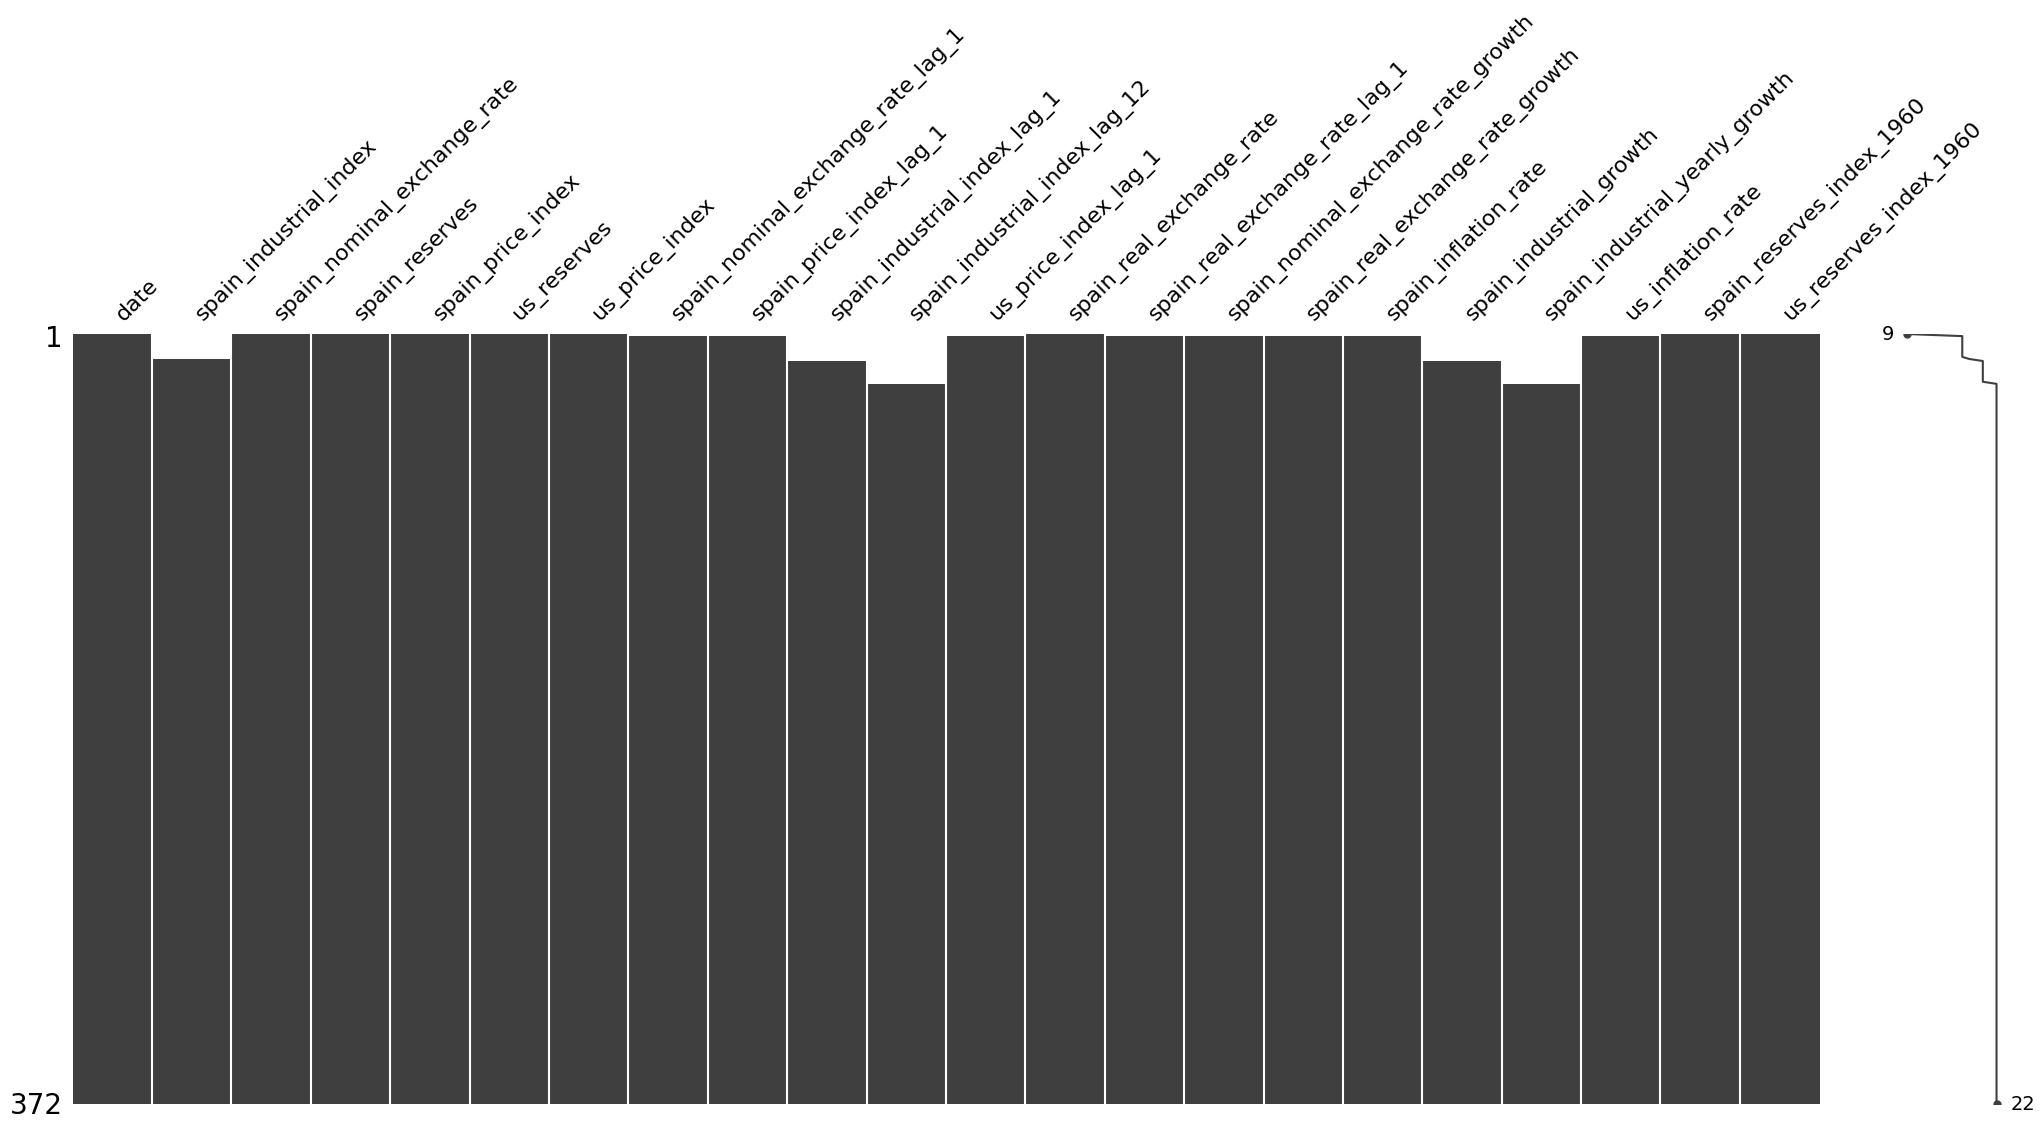

In [11]:
msno.matrix(df)

From the graph above, we can see that:
- Some variables have initial missing values
- There are no missing values in between
- On a closer inspection, only `_industrial_` columns have initial missing values

Since the values were missing in the raw data to begin with, we will leave the dataframe unchanged.

### **Any outliers?**

There are multiple ways to identify potential outliers. Before we decide on the method, we first ran the following code to plot each of the variables using histograms:

```python
for item in df.columns[1:]: # All variables except for 'date'
    plt.figure()
    plt.hist(df[item], bins=50, edgecolor='white')
    plt.title(str(item))
```
<u>Some observations:</u>
- Only a few distributions seem to be normal
- Some have some form of skewed distribution, some seems to have a uniform distribution for a certain range of values, others have distributions that seem very random

Therefore, in this case, the method of using standard deviation (considering values beyond a certain standard deviation as outliers) may not be appropriate. The method that we use is simply an empirical way of spotting extreme outliers ourselves from the distributions (there are not many of them).

<u>Variables that have outliers:</u>
- `spain_nominal_exchange_rate_growth`
- `spain_real_exchange_rate_growth`
- `spain_industrial_yearly_growth`
- `spain_inflation_rate`

For visualisation, we plot these variables:

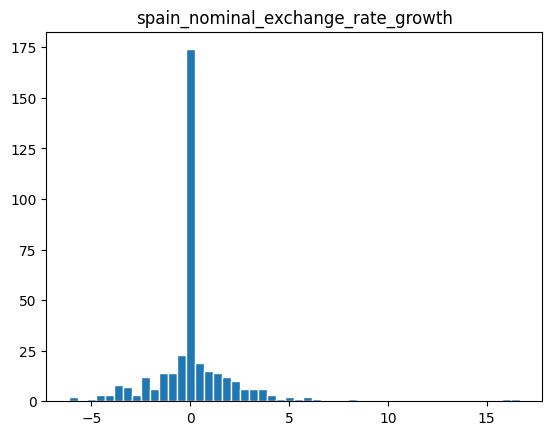

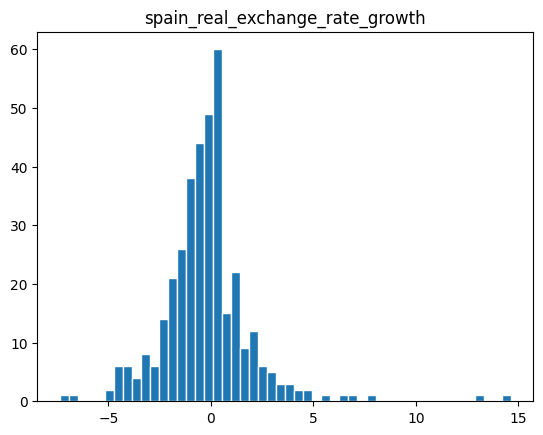

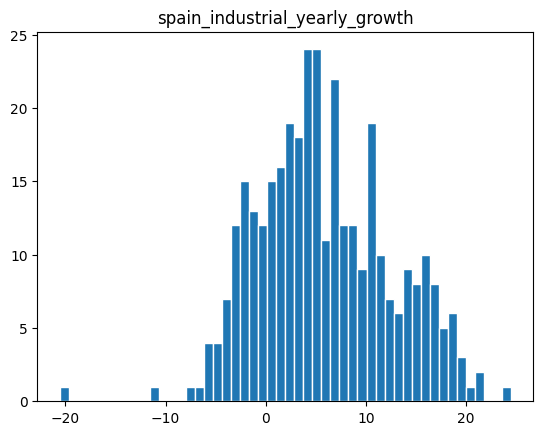

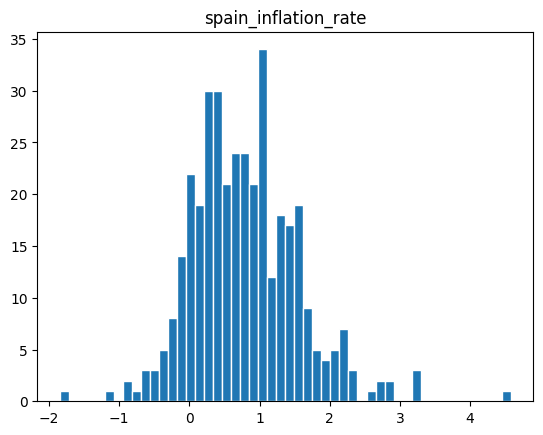

In [12]:
# Identify variables to inspect
factors_to_inspect = ['spain_nominal_exchange_rate_growth', 'spain_real_exchange_rate_growth', 'spain_industrial_yearly_growth', 'spain_inflation_rate']

# Plot each of the variable
for factor in factors_to_inspect:
    plt.figure()
    plt.hist(df[factor], bins=50, edgecolor='white')
    plt.title(str(factor))

To identify where the outliers exist in the dataframe, we build a custom function as such:

In [13]:
def determine_outlier_year(df, column_name, value, greater=True):
    '''
    parameters:
    df: the dataframe to inspect
    column_name: the variable to inspect
    value: the threshold value, determined empirically from histogram distribution, of outliers
    greater: set as 'True' for default (whether outliers are greater than/less than the threshold value)
    '''
    if greater:
        df_filtered = df[df[column_name] > value]
    else:
        df_filtered = df[df[column_name] <= value]

# We are only interested in the outlier rows
    return df_filtered

We first start with `spain_nominal_exchange_rate_growth` and `spain_real_exchange_rate_growth` (since they are closely correlated):

In [14]:
determine_outlier_year(df, 'spain_nominal_exchange_rate_growth', 15)

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index,us_reserves,us_price_index,spain_nominal_exchange_rate_lag_1,spain_price_index_lag_1,spain_industrial_index_lag_1,...,spain_real_exchange_rate,spain_real_exchange_rate_lag_1,spain_nominal_exchange_rate_growth,spain_real_exchange_rate_growth,spain_inflation_rate,spain_industrial_growth,spain_industrial_yearly_growth,us_inflation_rate,spain_reserves_index_1960,us_reserves_index_1960
94,1967-11-01,37.187341,70.0,1032.01,4.687126,15437.6,15.500641,60.0,4.591495,35.991154,...,231.494699,201.957497,16.666667,14.625455,2.082787,3.323558,1.634615,0.296736,442.922747,71.876004
210,1977-07-01,71.540634,80.52,4634.958238,13.491643,18926.987005,27.974529,69.309,13.063334,77.188579,...,166.955873,147.692095,16.175388,13.043201,3.278716,-7.317073,-3.553299,0.494234,1989.252463,88.122259


In [15]:
determine_outlier_year(df, 'spain_real_exchange_rate_growth', 10)

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index,us_reserves,us_price_index,spain_nominal_exchange_rate_lag_1,spain_price_index_lag_1,spain_industrial_index_lag_1,...,spain_real_exchange_rate,spain_real_exchange_rate_lag_1,spain_nominal_exchange_rate_growth,spain_real_exchange_rate_growth,spain_inflation_rate,spain_industrial_growth,spain_industrial_yearly_growth,us_inflation_rate,spain_reserves_index_1960,us_reserves_index_1960
94,1967-11-01,37.187341,70.0,1032.01,4.687126,15437.6,15.500641,60.0,4.591495,35.991154,...,231.494699,201.957497,16.666667,14.625455,2.082787,3.323558,1.634615,0.296736,442.922747,71.876004
210,1977-07-01,71.540634,80.52,4634.958238,13.491643,18926.987005,27.974529,69.309,13.063334,77.188579,...,166.955873,147.692095,16.175388,13.043201,3.278716,-7.317073,-3.553299,0.494234,1989.252463,88.122259


The outliers are in years 1967 and 1977. Upon further research:
- **(1967)** Spanish peseta's nominal exchange rate changed from 60 to 70 USD. This adjustment was part of Spain's efforts to stabilize its currency and manage its exchange rate within the framework of the Bretton Woods system.
  - <u>Classify as outlier</u> (one-time increase, endogenously influenced by policy)
- **(1977)** Spain was [transitioning from the dictatorship of Francisco Franco to a democratic system](
https://countrystudies.us/spain/52.htm). Uncertainty around Spain's political transition had an economic spillover effect, including high inflation rates and an unstable exchange rate.
  - <u>Do not classify as outlier</u> (natural exogenous events)

Now we inspect `spain_industrial_yearly_growth`:

In [16]:
determine_outlier_year(df, 'spain_industrial_yearly_growth', -15, greater=False)

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index,us_reserves,us_price_index,spain_nominal_exchange_rate_lag_1,spain_price_index_lag_1,spain_industrial_index_lag_1,...,spain_real_exchange_rate,spain_real_exchange_rate_lag_1,spain_nominal_exchange_rate_growth,spain_real_exchange_rate_growth,spain_inflation_rate,spain_industrial_growth,spain_industrial_yearly_growth,us_inflation_rate,spain_reserves_index_1960,us_reserves_index_1960
187,1975-08-01,46.40728,58.334,6485.817107,9.265871,16116.684976,24.901917,57.246,9.122712,66.457484,...,156.771924,155.974429,1.900569,0.511299,1.569256,-30.169972,-20.554247,0.184502,2783.612492,75.037759


- **(1975)** Similar to the source above, as Spain transitioned from a dictatorship regime into a democracy, the government failed to focus on the quadrupling of oil prices. This was problematic due to the nation's high dependence on imported sources of oil as a factor input for sources of capital production. This coincided with an outflow of labour from agricultural sectors despite falling job prospects in cities, leading to a rapid rise in unemployment and a fall in productivity, reducing industrial production.
    - <u>Do not classify as outlier</u> (natural endogenous events)

Finally, we inspect `spain_inflation_rate`:

In [17]:
determine_outlier_year(df, 'spain_inflation_rate', 4)

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index,us_reserves,us_price_index,spain_nominal_exchange_rate_lag_1,spain_price_index_lag_1,spain_industrial_index_lag_1,...,spain_real_exchange_rate,spain_real_exchange_rate_lag_1,spain_nominal_exchange_rate_growth,spain_real_exchange_rate_growth,spain_inflation_rate,spain_industrial_growth,spain_industrial_yearly_growth,us_inflation_rate,spain_reserves_index_1960,us_reserves_index_1960
196,1976-05-01,74.835268,67.629,5528.04471,10.754833,17955.330156,25.910835,67.271,10.283627,73.423282,...,162.933621,168.297389,0.532176,-3.187077,4.582095,1.923077,6.568365,0.713012,2372.551378,83.598317


Note that the year is in **1976**. Likewise, we do not classify this as an outlier.

Now we proceed to remove the outlier values. We will replace the values via the simple method of [linear interpolation](https://www.studysmarter.co.uk/explanations/math/statistics/linear-interpolation/), by taking the mean of the immediate values before and after. This is to ensure consistency and continuity of data.

We create a function to do so:

In [18]:
def identify_and_replace_outlier(row_index, column_name):
    df.loc[row_index, column_name] = (
        df.loc[row_index - 1, column_name] + df.loc[row_index + 1, column_name] # Taking mean value
    ) / 2


Now we apply the function:

In [19]:
# Initiate list of lists for the outliers identified above
values_to_replace = [
    [94, 'spain_nominal_exchange_rate_growth'],
    [94, 'spain_real_exchange_rate_growth']
]

# Apply the function
for outlier_index in values_to_replace:
    identify_and_replace_outlier(outlier_index[0], outlier_index[1])

Lastly, we save the dataframe into two versions:
- Clean version `df_clean`: data converted to two decimal places
- Raw version `df`: for future manipulations/calculations, if needed

In [20]:
df_clean = df

df_clean.iloc[:, 1:] = df_clean.iloc[:, 1:].astype(float).round(2)

df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)

Finally, we print the full dataframe `df_clean`. As there is a significant number of rows, we use the `IPython` package to create a dropdown button instead.

In [21]:
# Display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Create dropdown button
html_code = f'''
<details>
<summary style="font-size: 20px; font-weight: bold;">Click to open full dataframe</summary>
{df_clean.to_html()}
</details>
'''

# Display the HTML code
display(HTML(html_code))

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index,us_reserves,us_price_index,spain_nominal_exchange_rate_lag_1,spain_price_index_lag_1,spain_industrial_index_lag_1,spain_industrial_index_lag_12,us_price_index_lag_1,spain_real_exchange_rate,spain_real_exchange_rate_lag_1,spain_nominal_exchange_rate_growth,spain_real_exchange_rate_growth,spain_inflation_rate,spain_industrial_growth,spain_industrial_yearly_growth,us_inflation_rate,spain_reserves_index_1960,us_reserves_index_1960
0,1960-01-01,NaN,60.0,233.0,2.86,21478.1,13.44,NaN,NaN,NaN,NaN,NaN,282.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00,100.00
1,1960-02-01,NaN,60.0,253.0,2.86,21395.7,13.48,60.0,2.86,NaN,NaN,13.44,283.35,282.15,0.0,0.42,-0.08,NaN,NaN,0.34,108.58,99.62
2,1960-03-01,NaN,60.0,299.0,2.85,21344.7,13.48,60.0,2.86,NaN,NaN,13.48,283.69,283.35,0.0,0.12,-0.12,NaN,NaN,0.0,128.33,99.38
3,1960-04-01,NaN,60.0,326.0,2.85,21278.0,13.53,60.0,2.85,NaN,NaN,13.48,284.43,283.69,0.0,0.26,0.08,NaN,NaN,0.34,139.91,99.07
4,1960-05-01,NaN,60.0,360.0,2.85,21234.3,13.53,60.0,2.85,NaN,NaN,13.53,285.29,284.43,0.0,0.31,-0.3,NaN,NaN,0.0,154.51,98.86
5,1960-06-01,NaN,60.0,406.0,2.84,21169.8,13.57,60.0,2.85,NaN,NaN,13.53,286.5,285.29,0.0,0.42,-0.08,NaN,NaN,0.34,174.25,98.56
6,1960-07-01,NaN,60.0,427.0,2.84,20999.4,13.57,60.0,2.84,NaN,NaN,13.57,286.61,286.5,0.0,0.04,-0.04,NaN,NaN,0.0,183.26,97.77
7,1960-08-01,NaN,60.0,455.0,2.85,20803.4,13.57,60.0,2.84,NaN,NaN,13.57,286.03,286.61,0.0,-0.2,0.2,NaN,NaN,0.0,195.28,96.86
8,1960-09-01,NaN,60.0,479.0,2.86,20430.0,13.57,60.0,2.85,NaN,NaN,13.57,284.29,286.03,0.0,-0.61,0.61,NaN,NaN,0.0,205.58,95.12
9,1960-10-01,NaN,60.0,527.0,2.87,20068.2,13.67,60.0,2.86,NaN,NaN,13.57,285.46,284.29,0.0,0.41,0.26,NaN,NaN,0.68,226.18,93.44


# 📊 **Graphic visualisation**

According to [US Department of State](https://history.state.gov/milestones/1969-1976/nixon-shock#:~:text=On%20August%2015%2C%201971%2C%20President%20Richard%20M.), the end of Bretton Woods system is **August 15, 1971**. Hence we create a variable `bw_year` for this date for ease of plotting later on:

In [22]:
bw_year = datetime(1971, 8, 15)

Now we proceed to plot the necessary graphs. Note that we used `matplotlib` package and `ggplot` (an R package) theme. The codes are all strictly within the [Matplotlib Documentation](https://matplotlib.org/stable/index.html) and they are self-explanatory.

⚠️ **Note:** we also need to create a `graphs` folder in the current working directory to save the plots. Either create the folder manually or enter command `mkdir graphs` in the terminal, under the current working directory.

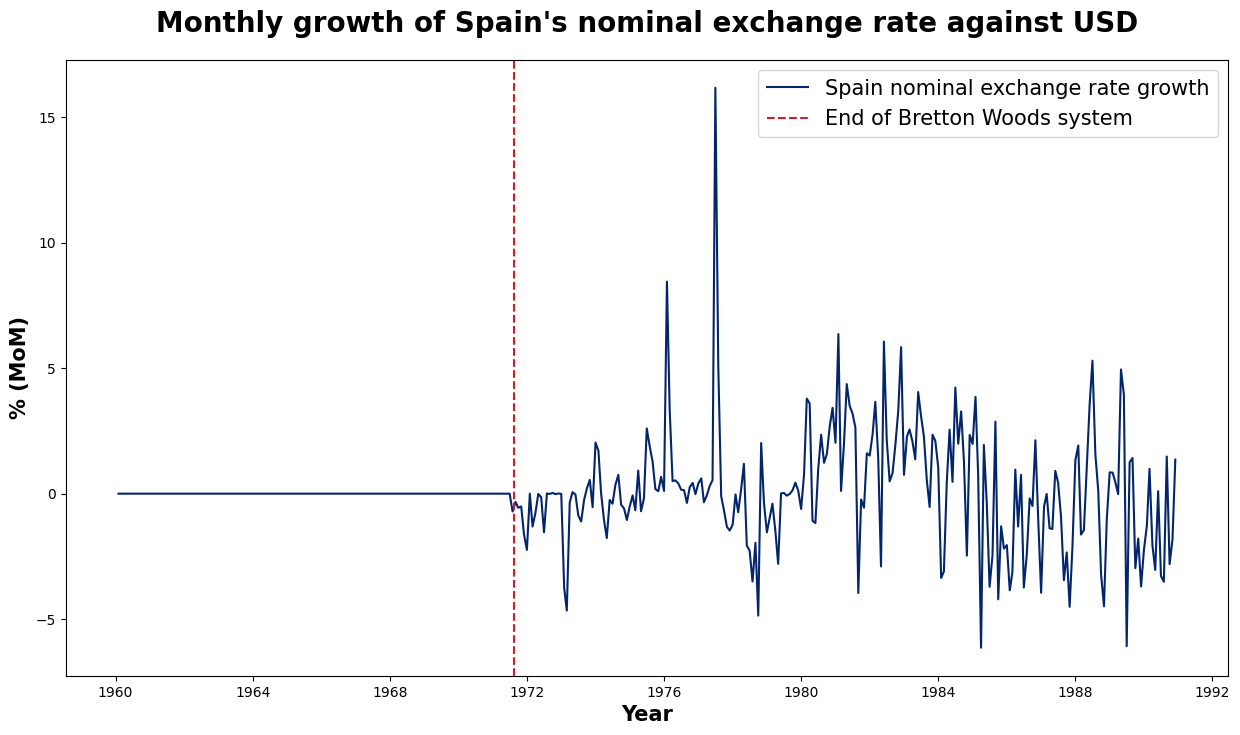

In [23]:
# Only this code chunk is fully commented, the rest of the plots are similar, and codes are very self-explanatory
# 'fontsize', 'weight', 'color', 'linestyle', 'pad' are purely for aesthetic purposes for good graphical design

# Create figure size that fits the notebook neatly
plt.figure(figsize = (15, 8))

# Plot the variables
plt.plot(df['date'], df['spain_nominal_exchange_rate_growth'], label='Spain nominal exchange rate growth', color='#03256C')

# Add the labels
plt.xlabel('Year', fontsize=15, weight='bold', color='black')
plt.ylabel('% (MoM)', fontsize=15, weight='bold', color='black')

# Add an additional line (if required, for e.g. to show time of end of Bretton Woods system)
plt.axvline(x=bw_year, color='#CD202C', linestyle='--', label='End of Bretton Woods system')

# Add title and legend
plt.title("Monthly growth of Spain's nominal exchange rate against USD", fontsize=20, weight='bold', pad=20)
plt.legend(fontsize=15)

# We adopt a consistent 'ggplot' theme throughout
plt.style.use('ggplot')

# Save as PNG with an appropriate name and resolution
plt.savefig("./graphs/Monthly growth of Spain's nominal exchange rate against USD.png", dpi=300)

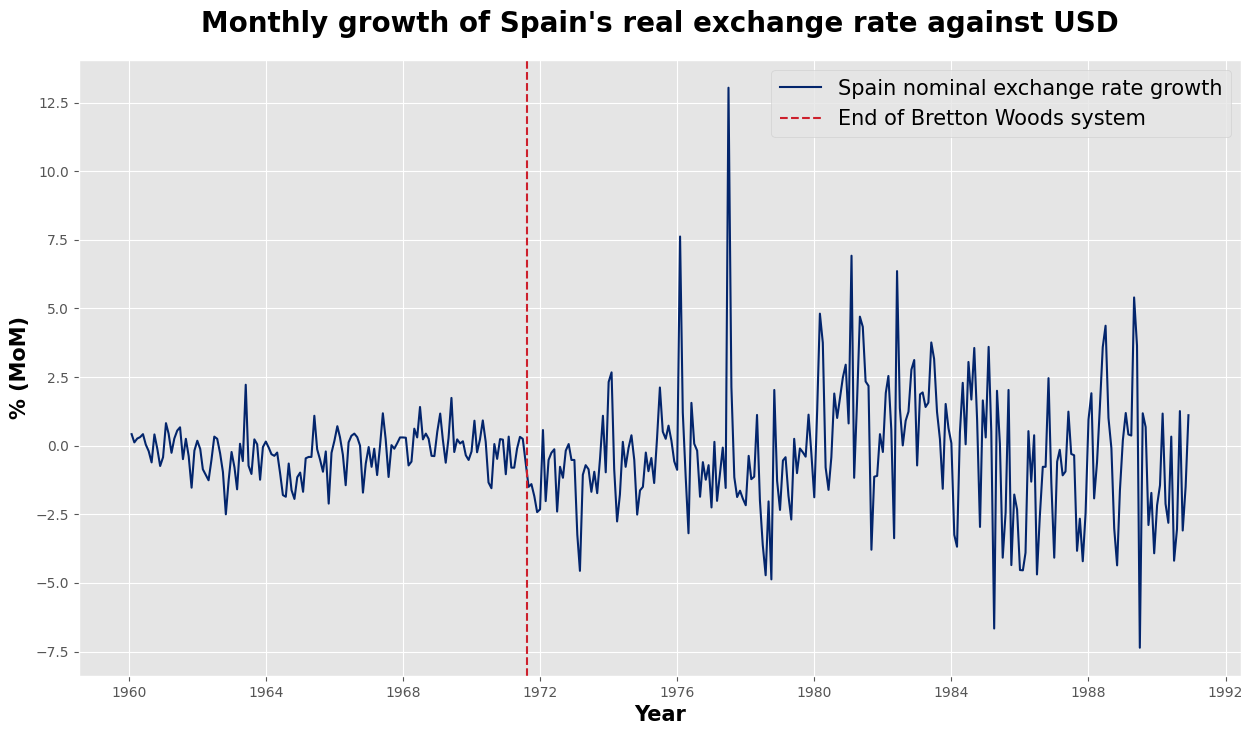

In [24]:
plt.figure(figsize = (15, 8))
plt.plot(df['date'], df['spain_real_exchange_rate_growth'], label='Spain nominal exchange rate growth', color='#03256C')
plt.xlabel('Year', fontsize=15, weight='bold', color='black')
plt.ylabel('% (MoM)', fontsize=15, weight='bold', color='black')
plt.axvline(x=bw_year, color='#CD202C', linestyle='--', label='End of Bretton Woods system')
plt.title("Monthly growth of Spain's real exchange rate against USD", fontsize=20, weight='bold', pad=20)
plt.legend(fontsize=15)
plt.style.use('ggplot')
plt.savefig("./graphs/Monthly growth of Spain's real exchange rate against USD.png", dpi=300)

We create additional plots:
- Spain's nominal exchange rate over time: to visualise a brief history of Spain's currency
- Comparision of the previous two graphs: to visualise the correlation between both variables before and after the Bretton Woods system

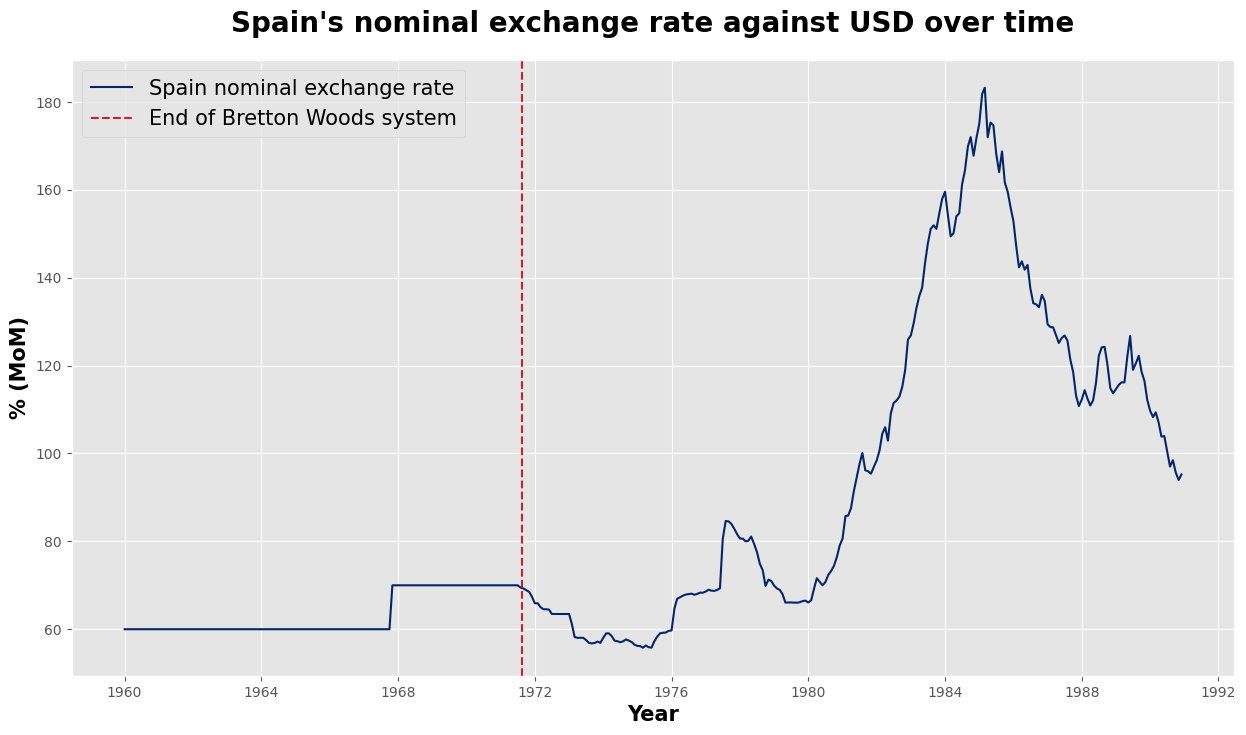

In [25]:
plt.figure(figsize = (15, 8))
plt.plot(df['date'], df['spain_nominal_exchange_rate'], label='Spain nominal exchange rate', color='#03256C')
plt.xlabel('Year', fontsize=15, weight='bold', color='black')
plt.ylabel('% (MoM)', fontsize=15, weight='bold', color='black')
plt.axvline(x=bw_year, color='#CD202C', linestyle='--', label='End of Bretton Woods system')
plt.title("Spain's nominal exchange rate against USD over time", fontsize=20, weight='bold', pad=20)
plt.legend(fontsize=15)
plt.style.use('ggplot')
plt.savefig("./graphs/Spain's nominal exchange rate against USD over time.png", dpi=300)

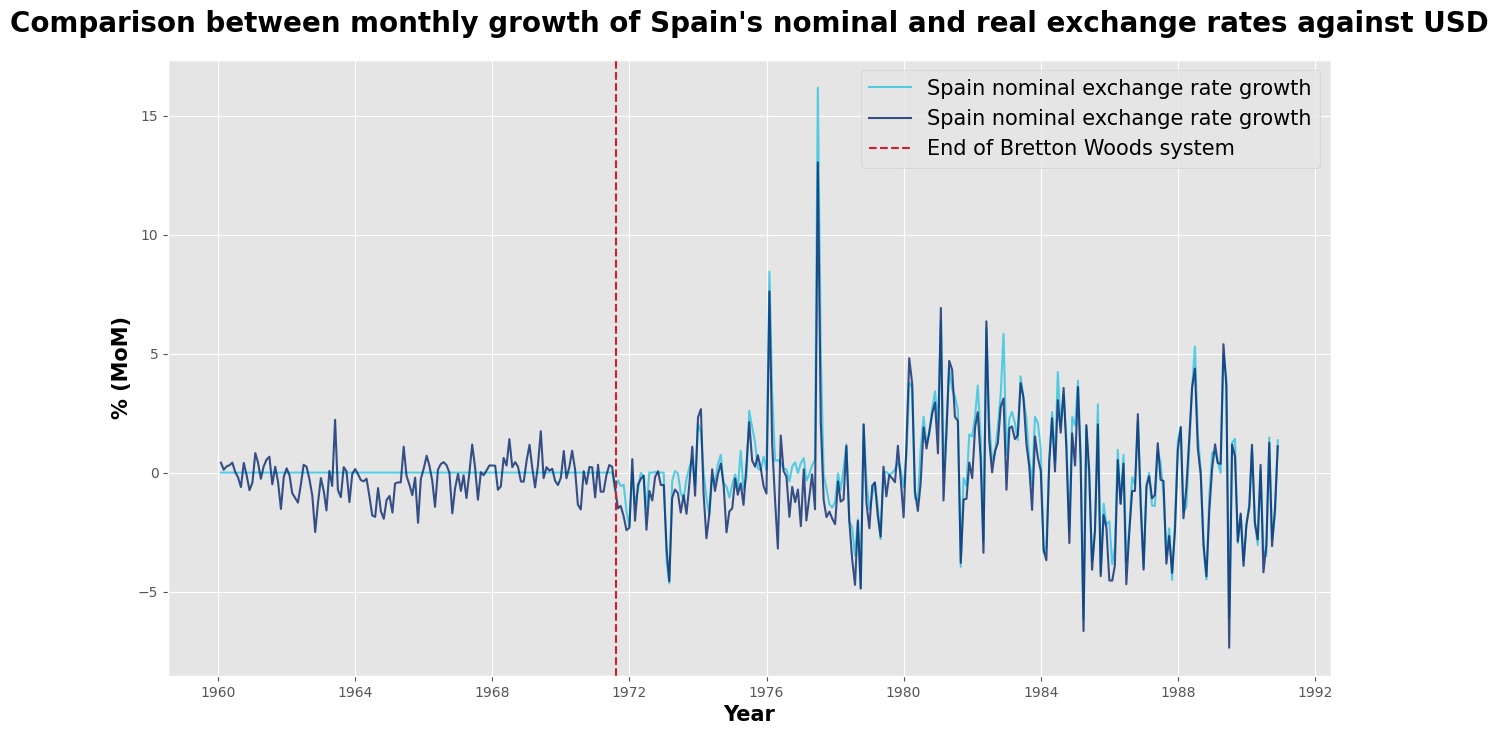

In [26]:
plt.figure(figsize = (15, 8))
plt.plot(df['date'], df['spain_nominal_exchange_rate_growth'], label='Spain nominal exchange rate growth', color='#06BEE1', alpha=0.66)
plt.plot(df['date'], df['spain_real_exchange_rate_growth'], label='Spain nominal exchange rate growth', color='#03256C', alpha=0.78)
plt.xlabel('Year', fontsize=15, weight='bold', color='black')
plt.ylabel('% (MoM)', fontsize=15, weight='bold', color='black')
plt.axvline(x=bw_year, color='#CD202C', linestyle='--', label='End of Bretton Woods system')
plt.title("Comparison between monthly growth of Spain's nominal and real exchange rates against USD", fontsize=20, weight='bold', pad=20)
plt.legend(fontsize=15)
plt.style.use('ggplot')
plt.savefig("./graphs/Comparison between monthly growth of Spain's nominal and real exchange rates against USD.png", dpi=300)

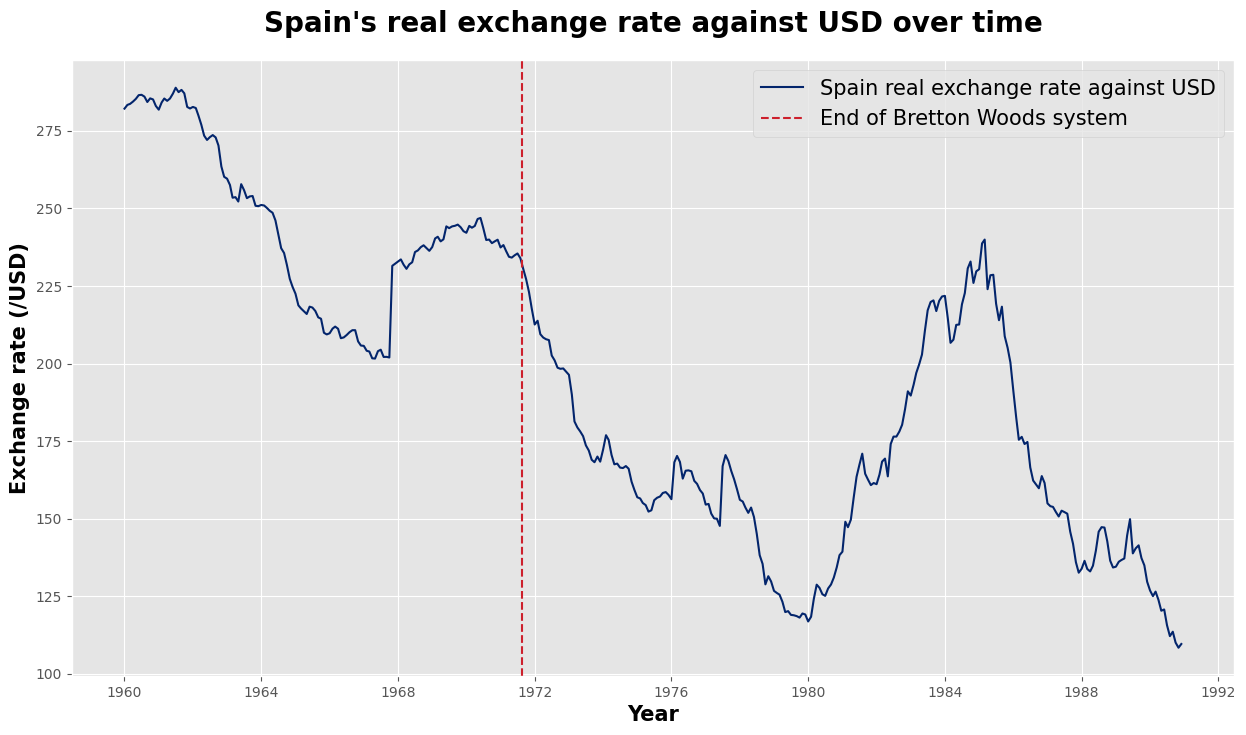

In [27]:
plt.figure(figsize = (15, 8))
plt.plot(df['date'], df['spain_real_exchange_rate'], label='Spain real exchange rate against USD', color='#03256C')
plt.xlabel('Year', fontsize=15, weight='bold', color='black')
plt.ylabel('Exchange rate (/USD)', fontsize=15, weight='bold', color='black')
plt.axvline(x=bw_year, color='#CD202C', linestyle='--', label='End of Bretton Woods system')
plt.title("Spain's real exchange rate against USD over time", fontsize=20, weight='bold', pad=20)
plt.legend(fontsize=15)
plt.style.use('ggplot')
plt.savefig("./graphs/Spain's real exchange rate against USD over time.png", dpi=300)

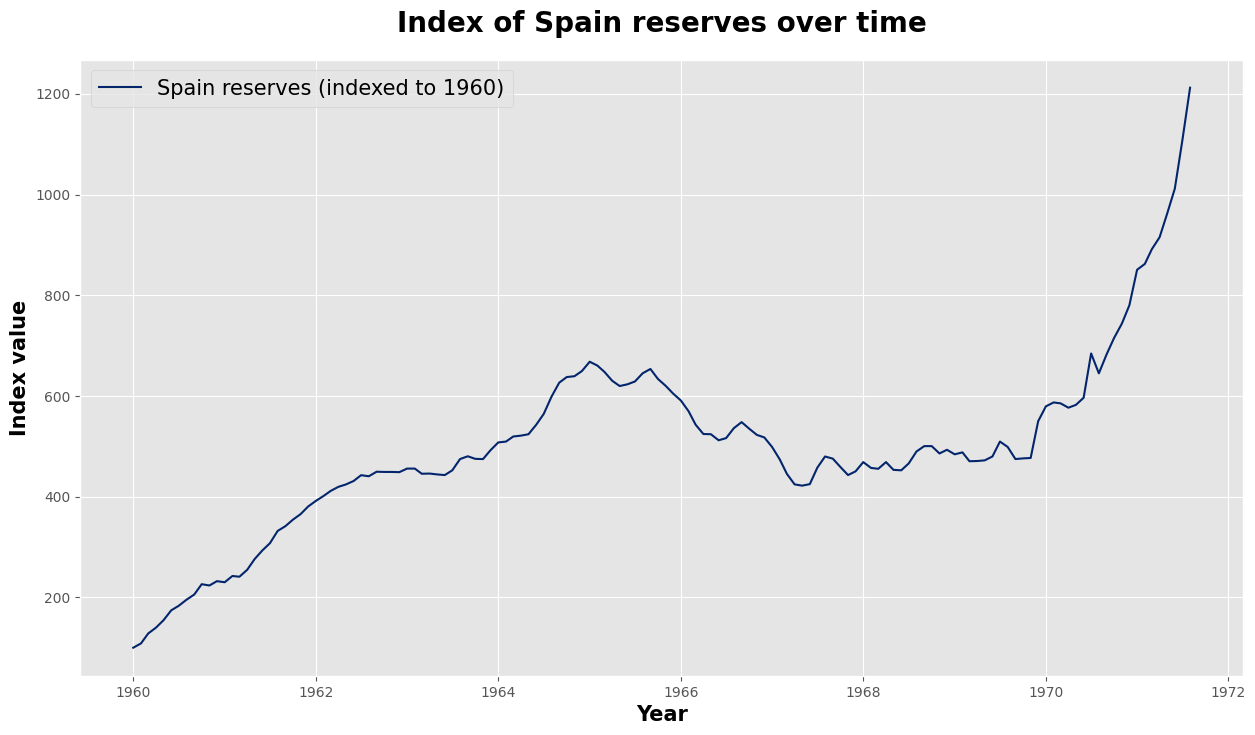

In [28]:
plt.figure(figsize = (15, 8))
plt.plot(df[df['date'] <= bw_year]['date'], # Only until 'bw_year'
         df[df['date'] <= bw_year]['spain_reserves_index_1960'], 
         label='Spain reserves (indexed to 1960)', color='#03256C')
# plt.plot(df[df['date'] <= bw_year]['date'], 
#          df[df['date'] <= bw_year]['us_reserves_index_1960'], 
#         label='US reserves (indexed to 1960)', color='#06BEE1')
plt.xlabel('Year', fontsize=15, weight='bold', color='black')
plt.ylabel('Index value', fontsize=15, weight='bold', color='black')
plt.title("Index of Spain reserves over time", fontsize=20, weight='bold', pad=20)
plt.legend(fontsize=15)
plt.style.use('ggplot')
plt.savefig("./graphs/spainreserves.png", dpi=300)

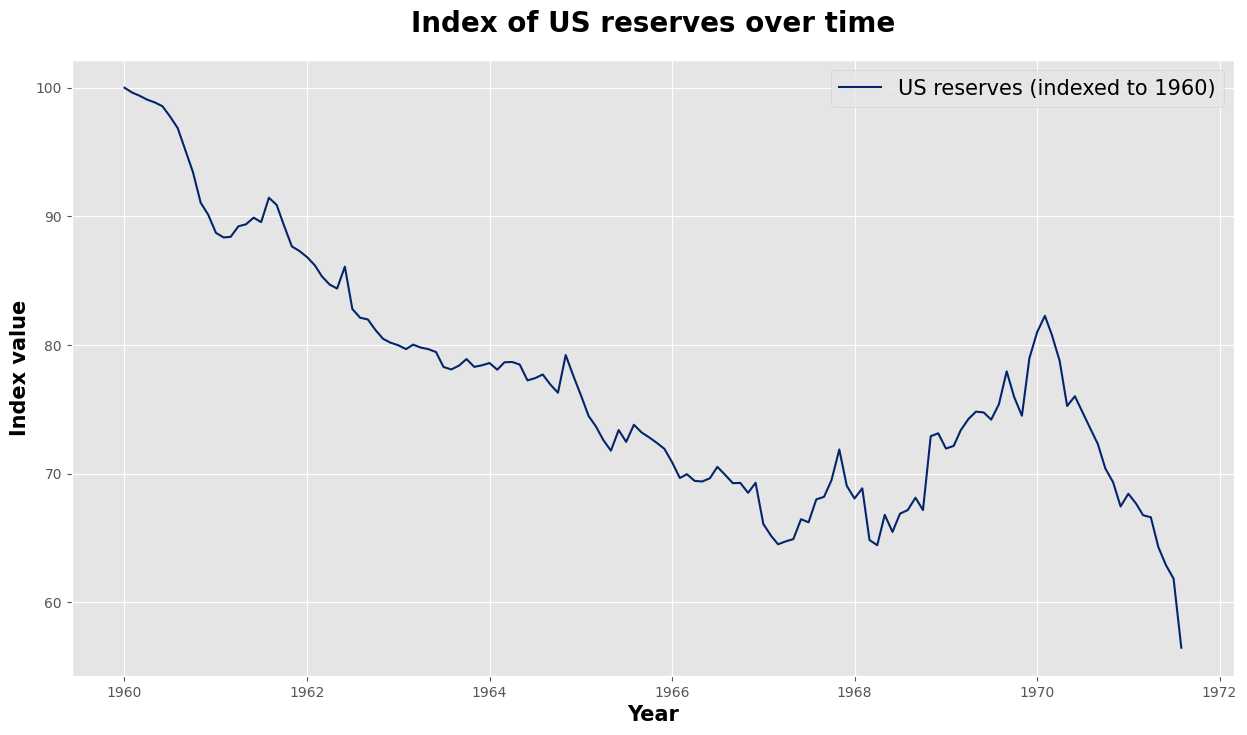

In [29]:
plt.figure(figsize = (15, 8))
#plt.plot(df[df['date'] <= bw_year]['date'], # Only until 'bw_year'
#         df[df['date'] <= bw_year]['spain_reserves_index_1960'], 
#         label='Spain reserves (indexed to 1960)', color='#03256C')
plt.plot(df[df['date'] <= bw_year]['date'], 
          df[df['date'] <= bw_year]['us_reserves_index_1960'], 
         label='US reserves (indexed to 1960)', color='#03256C')
plt.xlabel('Year', fontsize=15, weight='bold', color='black')
plt.ylabel('Index value', fontsize=15, weight='bold', color='black')
plt.title("Index of US reserves over time", fontsize=20, weight='bold', pad=20)
plt.legend(fontsize=15)
plt.style.use('ggplot')
plt.savefig("./graphs/usreserves.png", dpi=300)

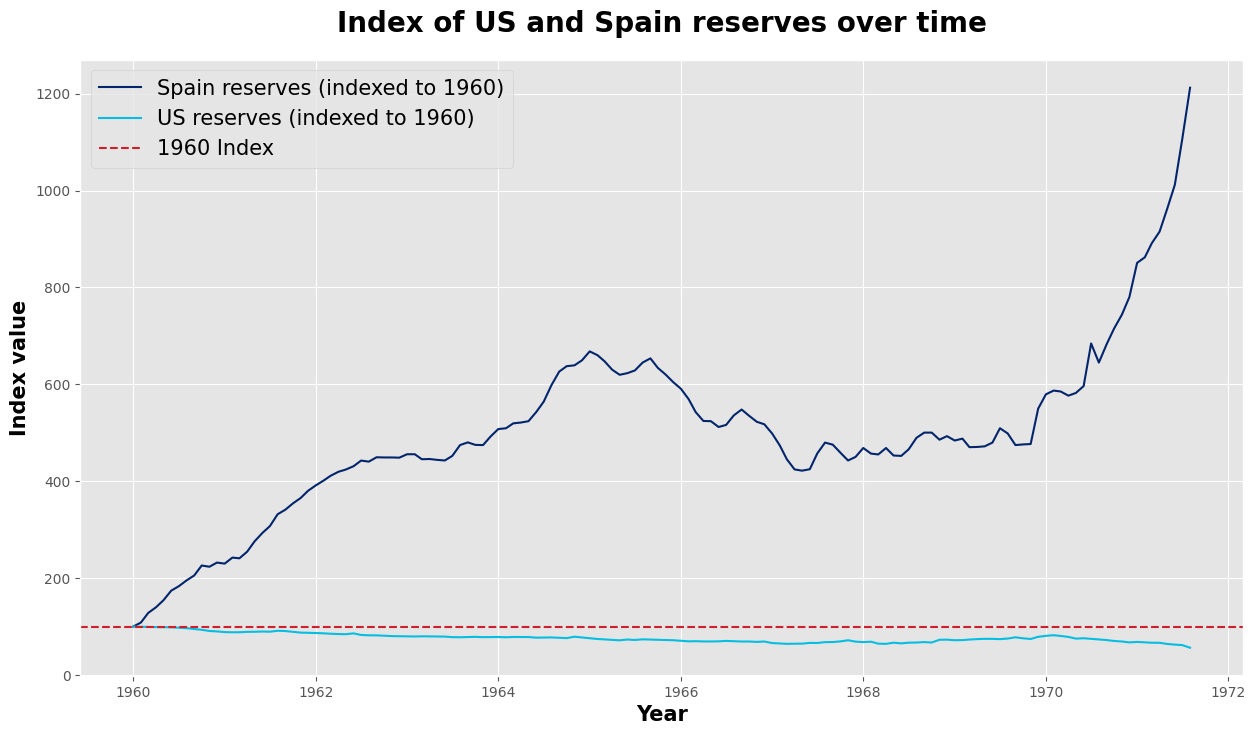

In [30]:
plt.figure(figsize = (15, 8))
plt.plot(df[df['date'] <= bw_year]['date'], # Only until 'bw_year'
         df[df['date'] <= bw_year]['spain_reserves_index_1960'], 
         label='Spain reserves (indexed to 1960)', color='#03256C')
plt.plot(df[df['date'] <= bw_year]['date'], 
         df[df['date'] <= bw_year]['us_reserves_index_1960'], 
         label='US reserves (indexed to 1960)', color='#06BEE1')
plt.xlabel('Year', fontsize=15, weight='bold', color='black')
plt.ylabel('Index value', fontsize=15, weight='bold', color='black')
plt.axhline(y=100, color='#CD202C', linestyle='--', label='1960 Index')
plt.title("Index of US and Spain reserves over time", fontsize=20, weight='bold', pad=20)
plt.legend(fontsize=15)
plt.style.use('ggplot')
plt.savefig("./graphs/Index of US and Spain reserves over time.png", dpi=300)

Clearly, the US index is much less significant compared to Spain's. To have a clearer visualisation, we plot a similar version of the above graph with two y-axis:

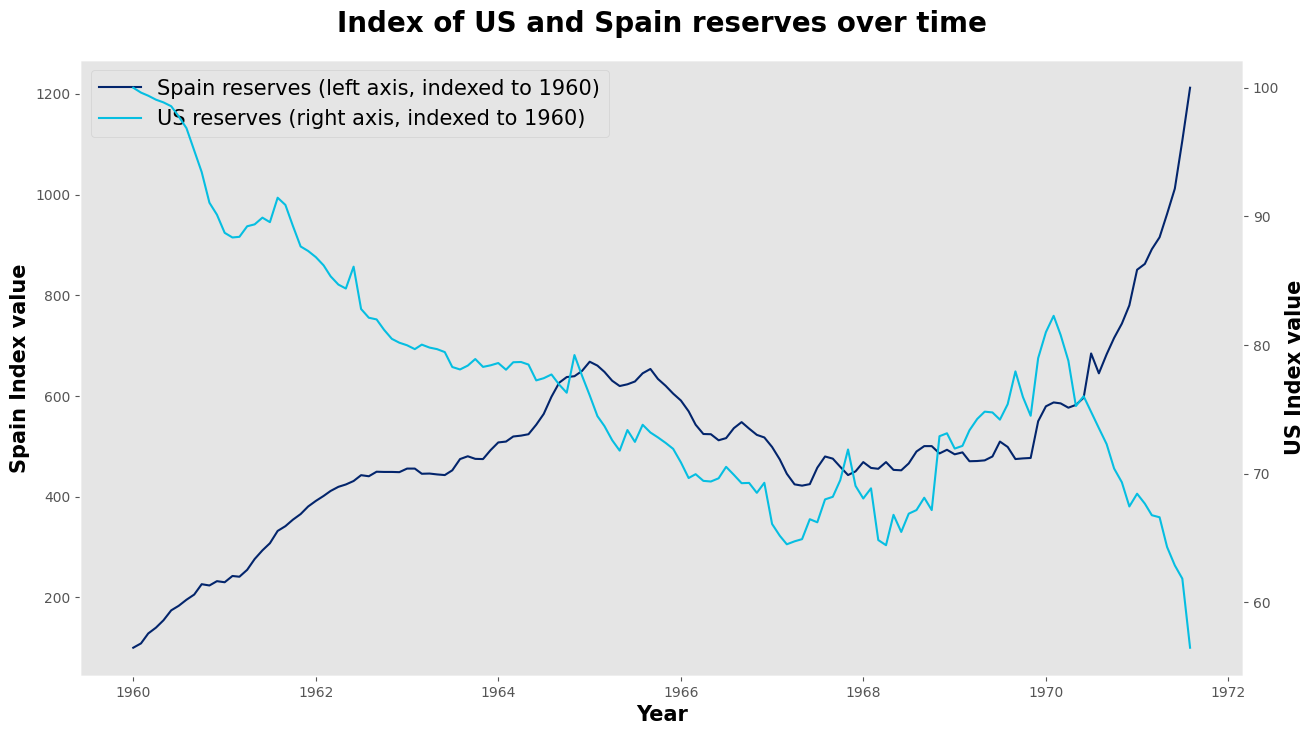

In [31]:
plt.figure(figsize=(15, 8))

# Y-axis for Spain's reserves
ax1 = plt.gca()
ax1.plot(df[df['date'] <= bw_year]['date'],
         df[df['date'] <= bw_year]['spain_reserves_index_1960'],
         label='Spain reserves (left axis, indexed to 1960)', color='#03256C')
ax1.set_xlabel('Year', fontsize=15, weight='bold', color='black')
ax1.set_ylabel('Spain Index value', fontsize=15, weight='bold', color='black')
plt.grid(False)

# Y-axis for US's reserves
ax2 = ax1.twinx()
ax2.plot(df[df['date'] <= bw_year]['date'],
         df[df['date'] <= bw_year]['us_reserves_index_1960'],
         label='US reserves (right axis, indexed to 1960)', color='#06BEE1')
ax2.set_ylabel('US Index value', fontsize=15, weight='bold', color='black')
plt.grid(False)

ax1.set_title("Index of US and Spain reserves over time", fontsize=20, weight='bold', pad=20)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, fontsize=15)
plt.style.use('ggplot')
plt.savefig("./graphs/Index of US and Spain reserves over time (double Y-axis).png", dpi=300)

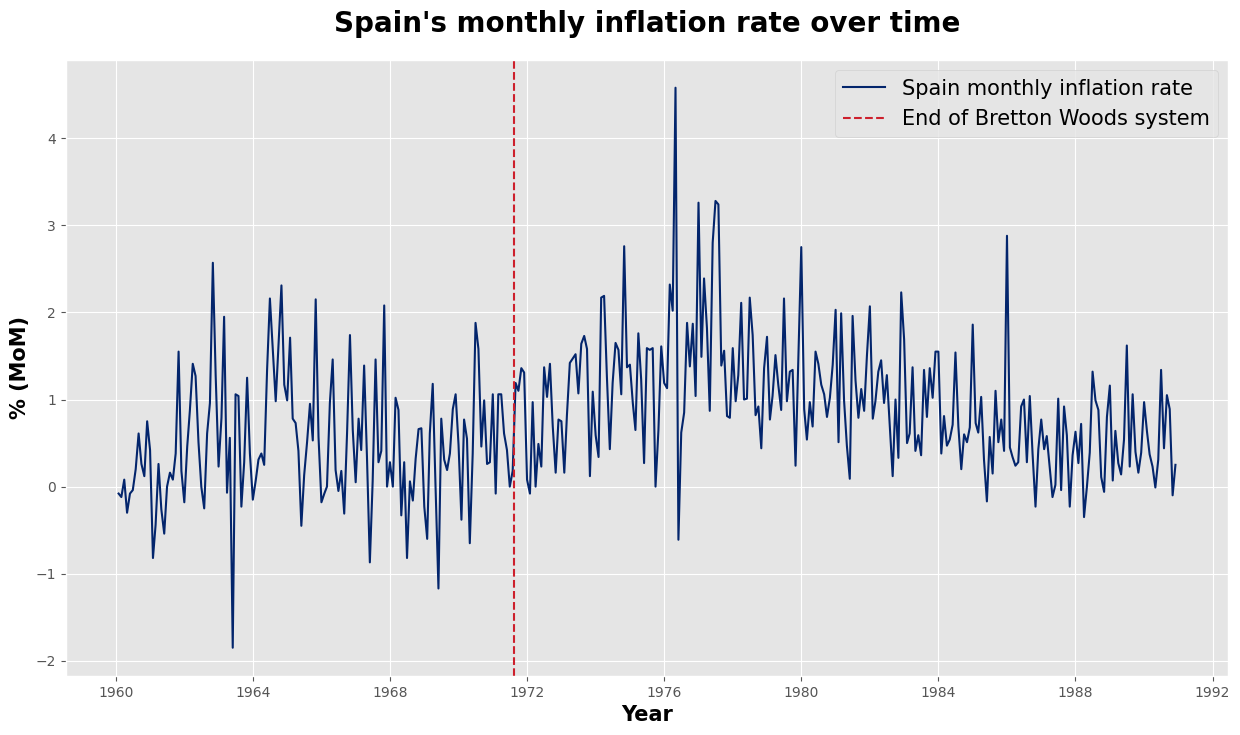

In [32]:
plt.figure(figsize = (15, 8))
plt.plot(df['date'], df['spain_inflation_rate'], label='Spain monthly inflation rate', color='#03256C')
plt.xlabel('Year', fontsize=15, weight='bold', color='black')
plt.ylabel('% (MoM)', fontsize=15, weight='bold', color='black')
plt.axvline(x=bw_year, color='#CD202C', linestyle='--', label='End of Bretton Woods system')
plt.title("Spain's monthly inflation rate over time", fontsize=20, weight='bold', pad=20)
plt.legend(fontsize=15)
plt.style.use('ggplot')
plt.savefig("./graphs/Spain's monthly inflation rate over time.png", dpi=300)

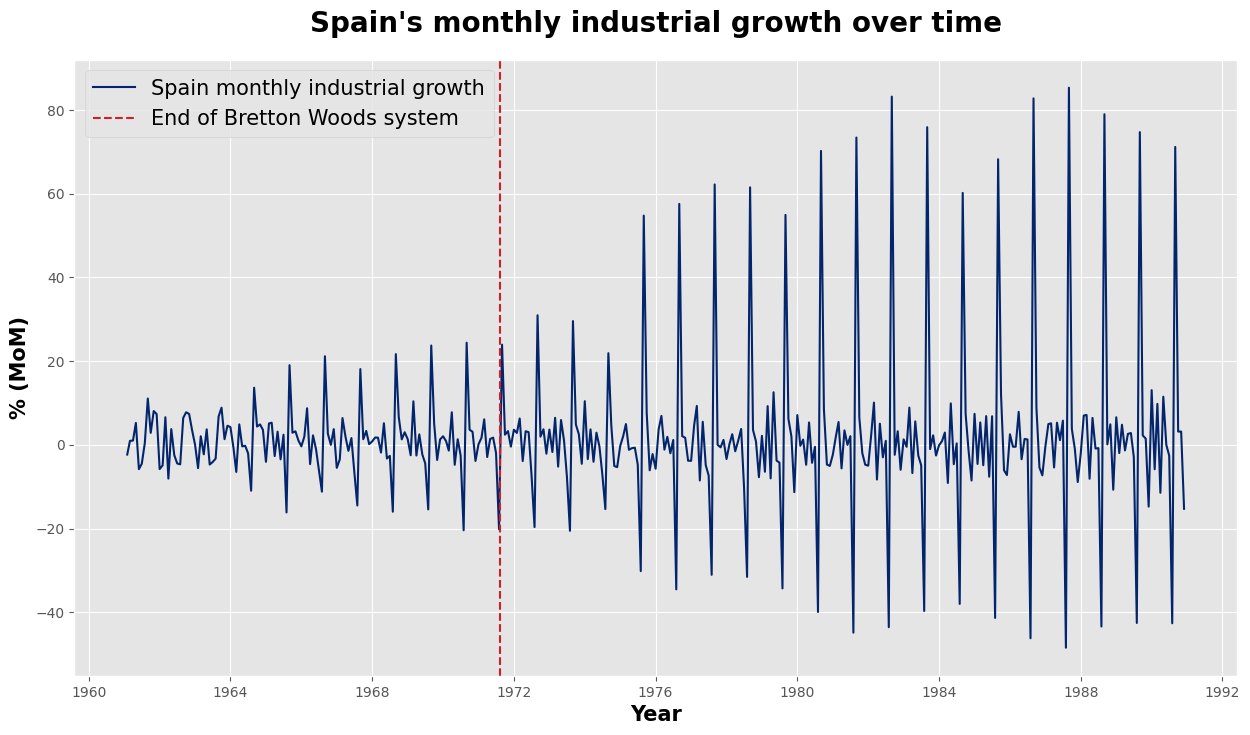

In [33]:
plt.figure(figsize = (15, 8))
plt.plot(df['date'], df['spain_industrial_growth'], label='Spain monthly industrial growth', color='#03256C')
plt.xlabel('Year', fontsize=15, weight='bold', color='black')
plt.ylabel('% (MoM)', fontsize=15, weight='bold', color='black')
plt.axvline(x=bw_year, color='#CD202C', linestyle='--', label='End of Bretton Woods system')
plt.title("Spain's monthly industrial growth over time", fontsize=20, weight='bold', pad=20)
plt.legend(fontsize=15)
plt.style.use('ggplot')
plt.savefig("./graphs/Spain's monthly industrial growth over time.png", dpi=300)

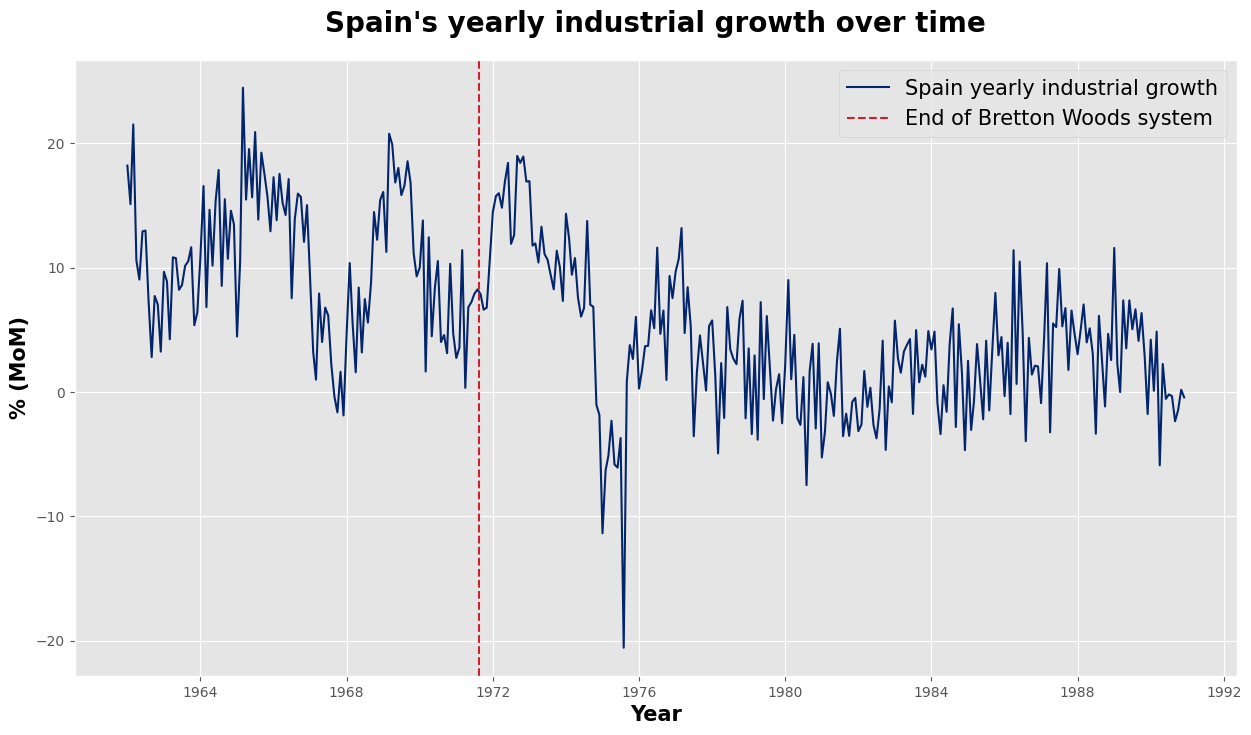

In [34]:
plt.figure(figsize = (15, 8))
plt.plot(df['date'], df['spain_industrial_yearly_growth'], label='Spain yearly industrial growth', color='#03256C')
plt.xlabel('Year', fontsize=15, weight='bold', color='black')
plt.ylabel('% (MoM)', fontsize=15, weight='bold', color='black')
plt.axvline(x=bw_year, color='#CD202C', linestyle='--', label='End of Bretton Woods system')
plt.title("Spain's yearly industrial growth over time", fontsize=20, weight='bold', pad=20)
plt.legend(fontsize=15)
plt.style.use('ggplot')
plt.savefig("./graphs/Spain's yearly industrial growth over time.png", dpi=300)

# 📑 **Statistical Analysis**

We first add an extra column in our dataframe – difference between US and Spain inflation rate defined as such:

In [35]:
df['us_minus_spain_inflation'] = df['us_inflation_rate'] - df['spain_inflation_rate']

We separate our dataframe into _before_ and _after_ the Bretton Woods system, with dates adjusted:

In [36]:
df_before = df[df['date'] <= pd.to_datetime('1971-07-01')]
df_after = df[df['date'] >= pd.to_datetime('1973-01-01')]

Finally, we calculate the standard deviations using `std()` in `pandas`.

In [37]:
# Identify the factors that we want to calculate standard deviation
std_factors = ['spain_nominal_exchange_rate_growth', 'spain_real_exchange_rate_growth', 'spain_inflation_rate', 'us_minus_spain_inflation', 'spain_industrial_yearly_growth']

# Create an empty dictionary (to be converted to tabular format later on)
std_values = {'before': {}, 'after': {}}

# Initiate loops to calculate each factor in each dataframe
for dataframe in [df_before, df_after]:
    for factor in std_factors:
        factor_std = dataframe[factor].std()
        std_values['before' if dataframe is df_before else 'after'][factor] = factor_std  # Store values accordingly

# Convert std_values dictionary to dataFrame
std_df = pd.DataFrame(std_values)
std_df['ratio (after/before)'] = std_df['after'] / std_df['before']
std_df = std_df.round(2) # Round to two decimal places

# Print the values
print("Standard deviations:")
print(std_df)

Standard deviations:
                                    before  after  ratio (after/before)
spain_nominal_exchange_rate_growth    0.00   2.58                   inf
spain_real_exchange_rate_growth       0.77   2.53                  3.29
spain_inflation_rate                  0.72   0.74                  1.02
us_minus_spain_inflation              0.79   0.75                  0.95
spain_industrial_yearly_growth        5.69   5.05                  0.89


Note that for `spain_nominal_exchange_rate_growth`, it is expected that it has a standard deviation of $0.00$ since the currency is pegged to US dollar (and we removed one outlier). 